# Self-Driving Car Engineer Nanodegree

## Project: Advance Lane Lines




### Import Libraries

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline


### Camera Calibration


In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# The given calibration images have grid size of 9 x 6
# prepare object points, (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#print(objpoints)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

image_files = glob.glob('camera_cal/*.jpg')

#print(image_files)

# calculate imgpoints from the given images
for imgfilename in image_files:
    img = cv2.imread(imgfilename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2=cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()


### Function to undistort images



In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


### Check the function using the calibration images


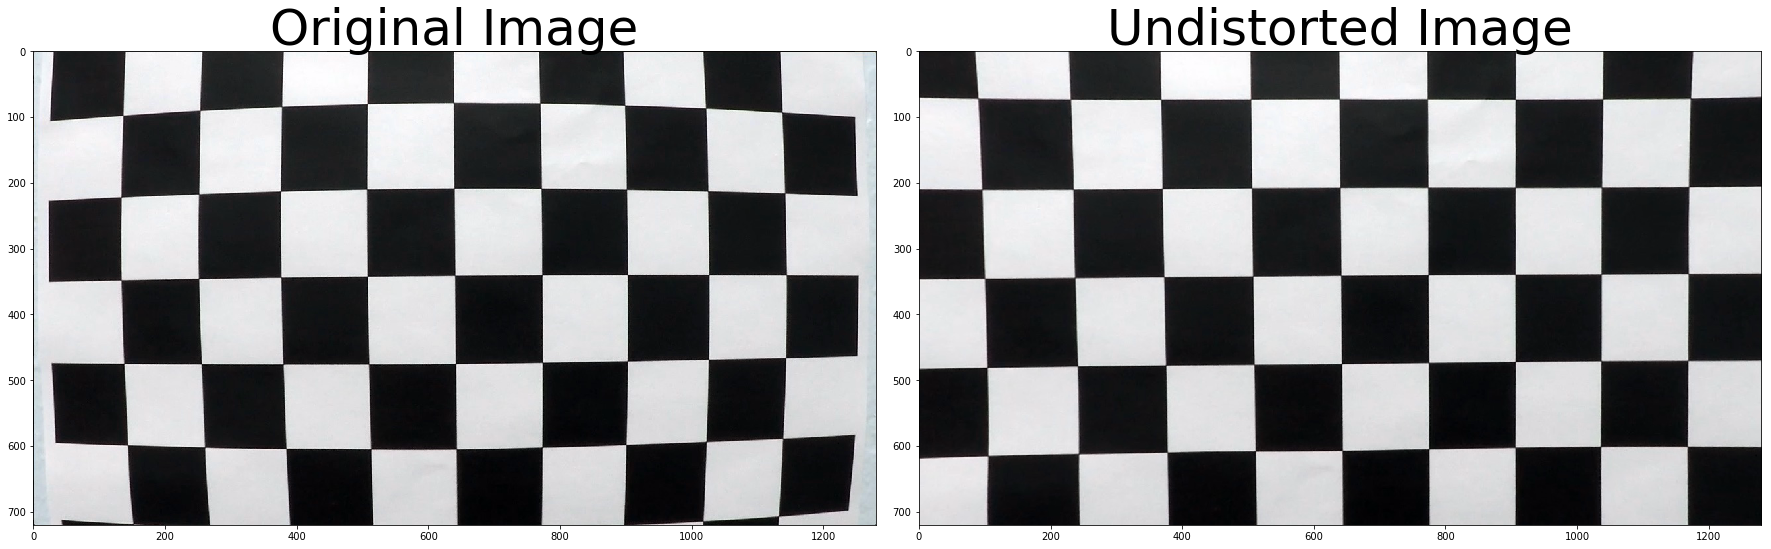

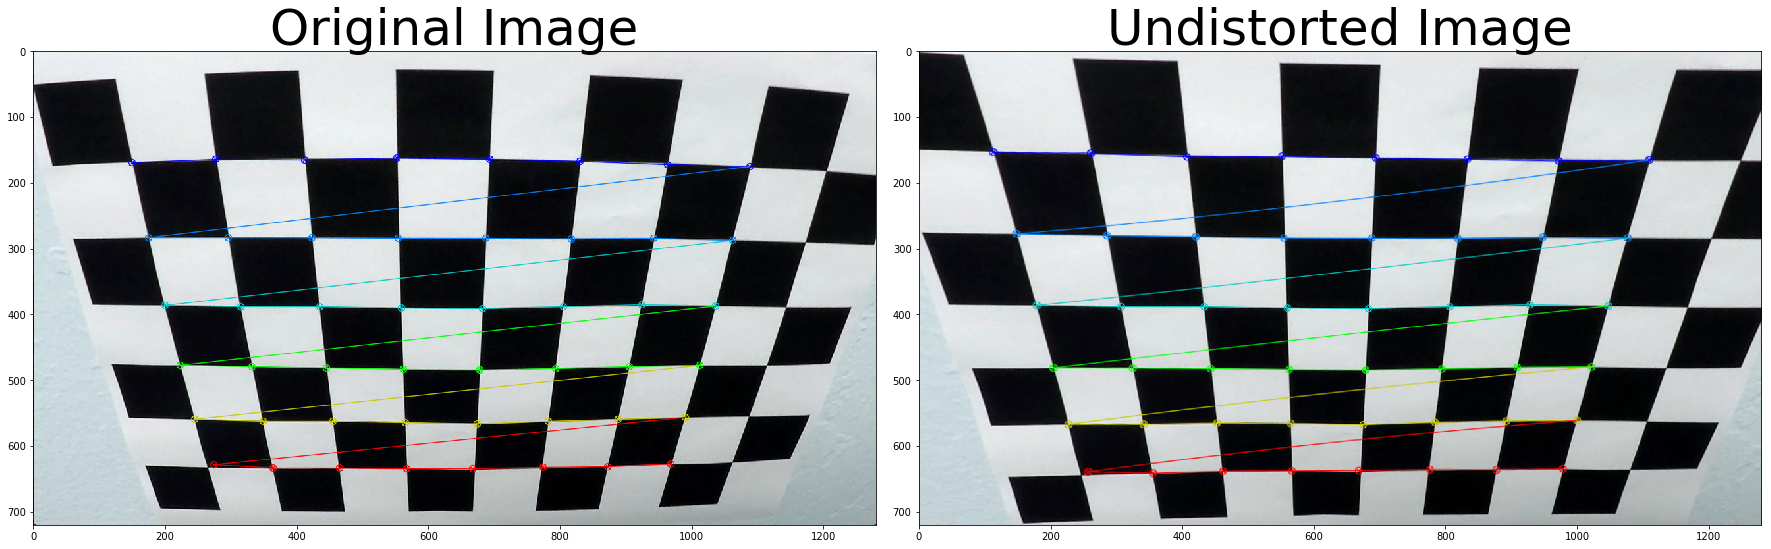

In [4]:
check_img_files = ['camera_cal/calibration1.jpg', 'camera_cal/calibration2.jpg']

for imgfilename in check_img_files:
    img = cv2.imread(imgfilename)
    undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now we have the camera calibration matrix and distortion coefficients.

In [5]:
print("mtx", mtx)
print("dist", dist)

mtx [[  1.15694047e+03   0.00000000e+00   6.65948820e+02]
 [  0.00000000e+00   1.15213880e+03   3.88784788e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist [[ -2.37638062e-01  -8.54041477e-02  -7.90999654e-04  -1.15882246e-04
    1.05725940e-01]]


In [6]:
# helper function to convert BGR images to RGB
def bgr_to_rgb(bgr_img):
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    return rgb_img

# helper function to convert RGB images to BGR
def rgb_to_bgr(bgr_img):
    r,g,b = cv2.split(bgr_img)       # get b,g,r
    bgr_img = cv2.merge([b,g,r])     # switch it to rgb
    return bgr_img


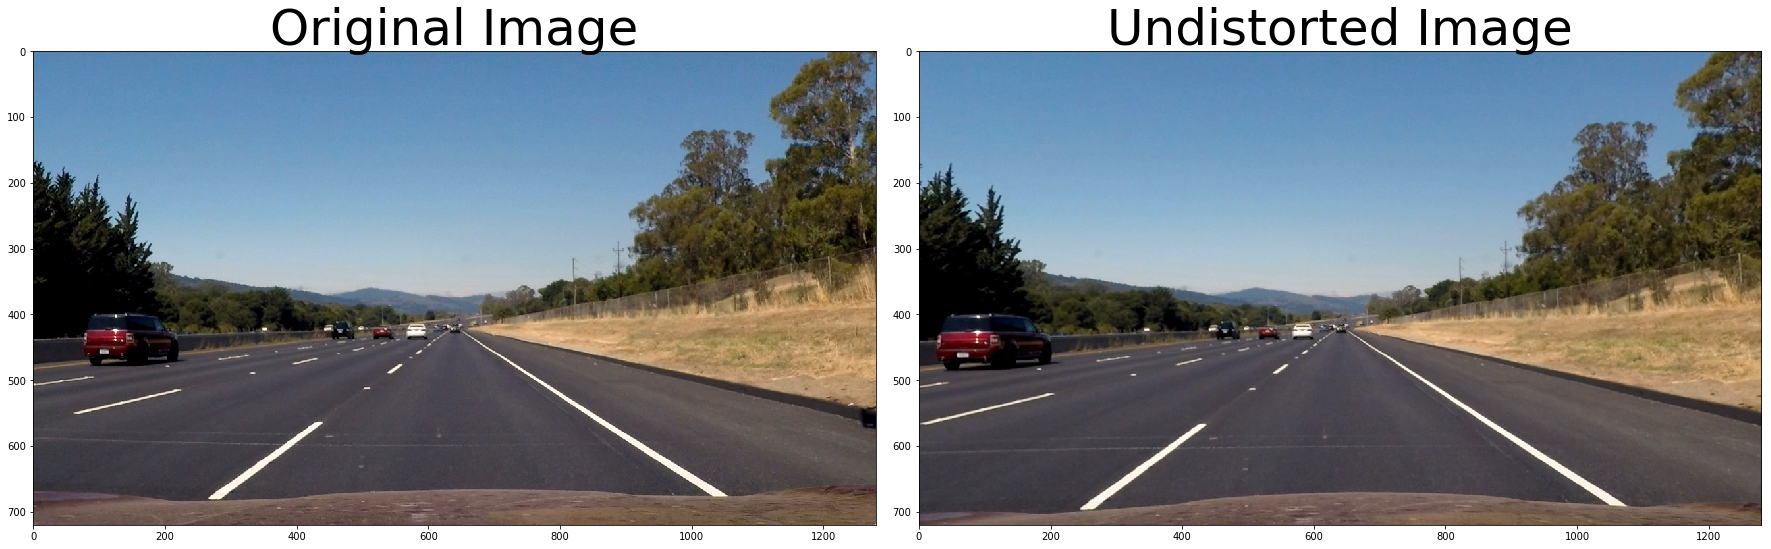

In [7]:
test_image_files = glob.glob('test_images/*.jpg')

img = cv2.imread(test_image_files[1])
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(img))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(bgr_to_rgb(undist))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

Color and gradient tresholding


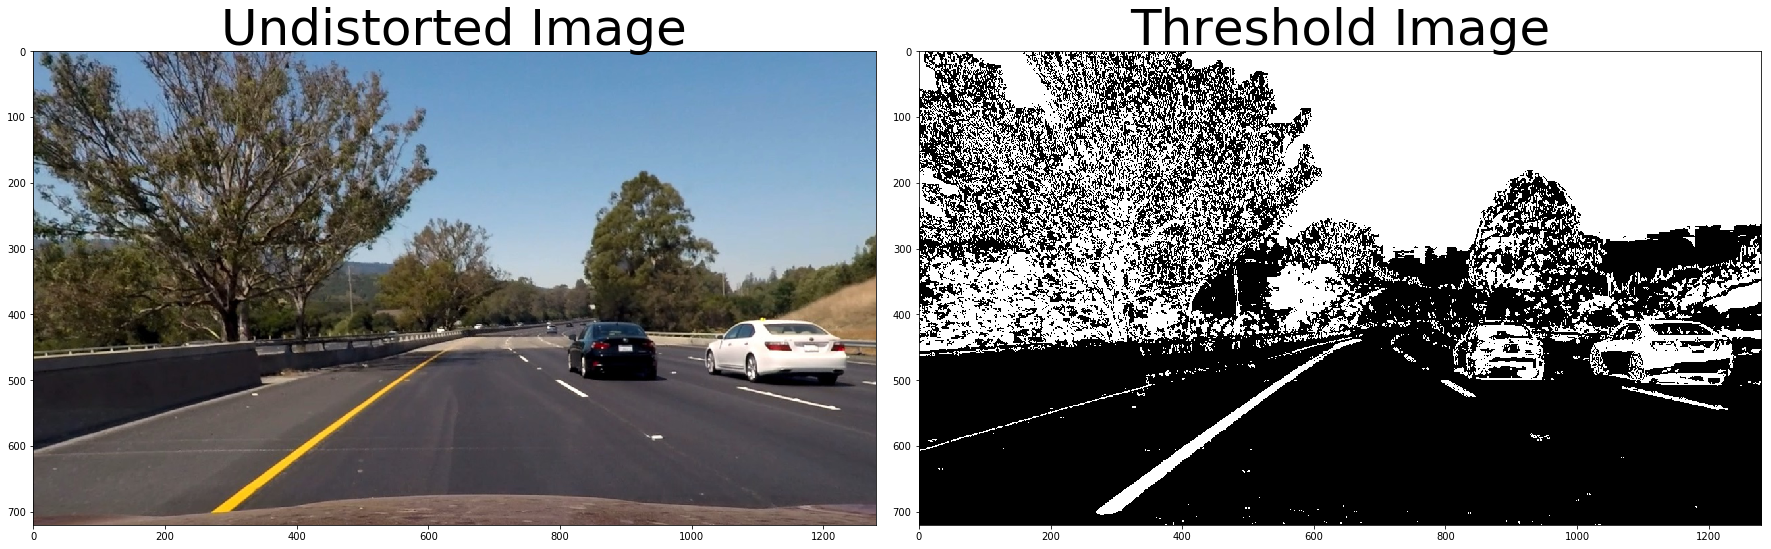

In [8]:
img = cv2.imread('test_images/test6.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 80
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(undist))
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Threshold Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Perspective Transform


Image Size (720, 1280, 3)


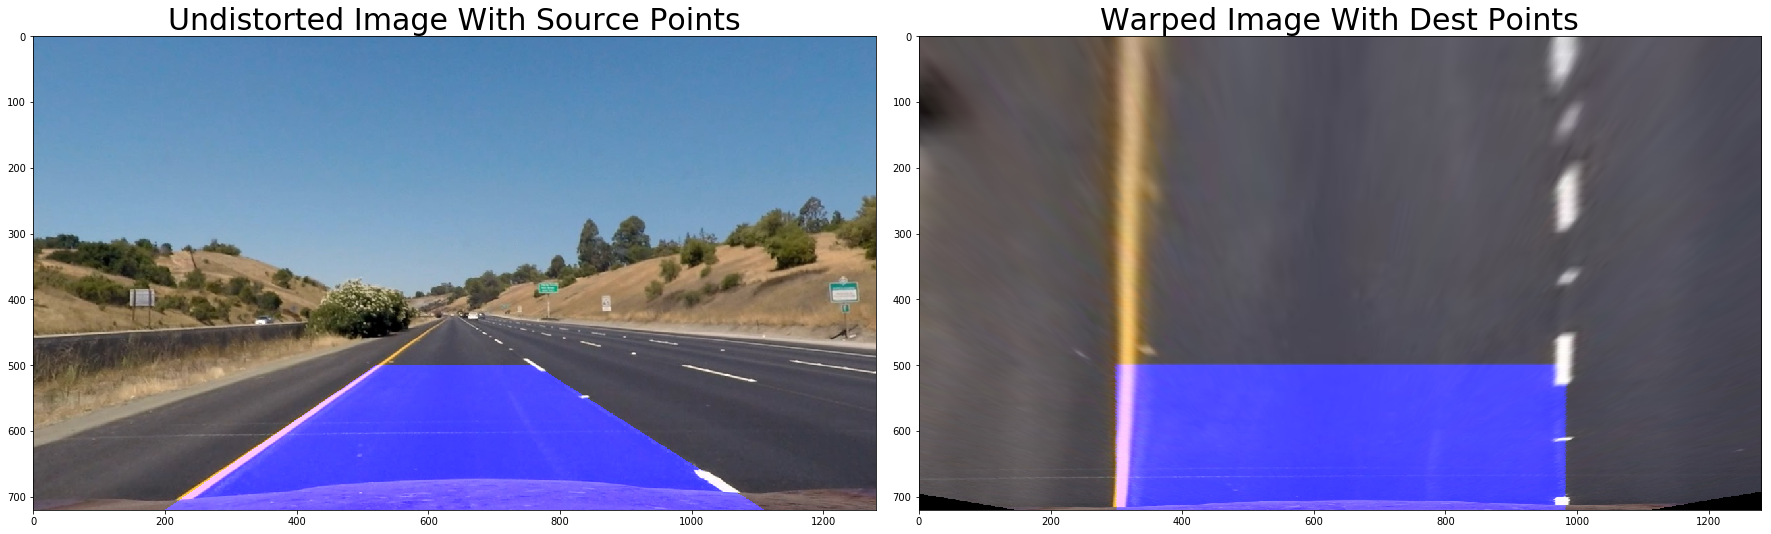

In [9]:
img = cv2.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

ignore_mask_color = 255
mask = np.zeros_like(undist)
imshape = undist.shape
print("Image Size",imshape)
vertices = np.array([[(200,imshape[0]),(520, 500), (763, 500), (1110,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_img = cv2.bitwise_or(undist, mask)


warp_vertices = np.array([[(300,imshape[0]),(300, 500), (imshape[1]-300, 500), (imshape[1]-300,imshape[0])]], dtype=np.int32)
M = cv2.getPerspectiveTransform(vertices.astype(np.float32), warp_vertices.astype(np.float32))
Minv = cv2.getPerspectiveTransform(warp_vertices.astype(np.float32), vertices.astype(np.float32))
warped = cv2.warpPerspective(masked_img, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(masked_img))
ax1.set_title('Undistorted Image With Source Points', fontsize=30)
ax2.imshow(bgr_to_rgb(warped))
ax2.set_title('Warped Image With Dest Points', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Combined Image Pipeline

Function depends on parameters saved as global variables above:
mtx
dist
M
imshape
thresh_min 
thresh_max 
s_thresh_min
s_thresh_max

In [10]:
def source_img_to_wrap(img):
    global mtx
    global dist
    global M
    global imshape
    global thresh_min
    global thresh_max
    global s_thresh_min
    global s_thresh_max
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return warped, undist



In [11]:
def source_img_to_wrap_2(img):
    global mtx
    global dist
    global M
    global imshape
    global thresh_min
    global thresh_max
    global s_thresh_min
    global s_thresh_max
    s_thresh_min = 80
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    warped = cv2.warpPerspective(undist, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
    gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
    
    #for x in np.nditer(gray, op_flags=['readwrite']):
    #    if x < 100:
    #        x[...] = 100


    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    #s_channel = warped[:,:,0]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    #combined_binary = s_binary
    return combined_binary, undist

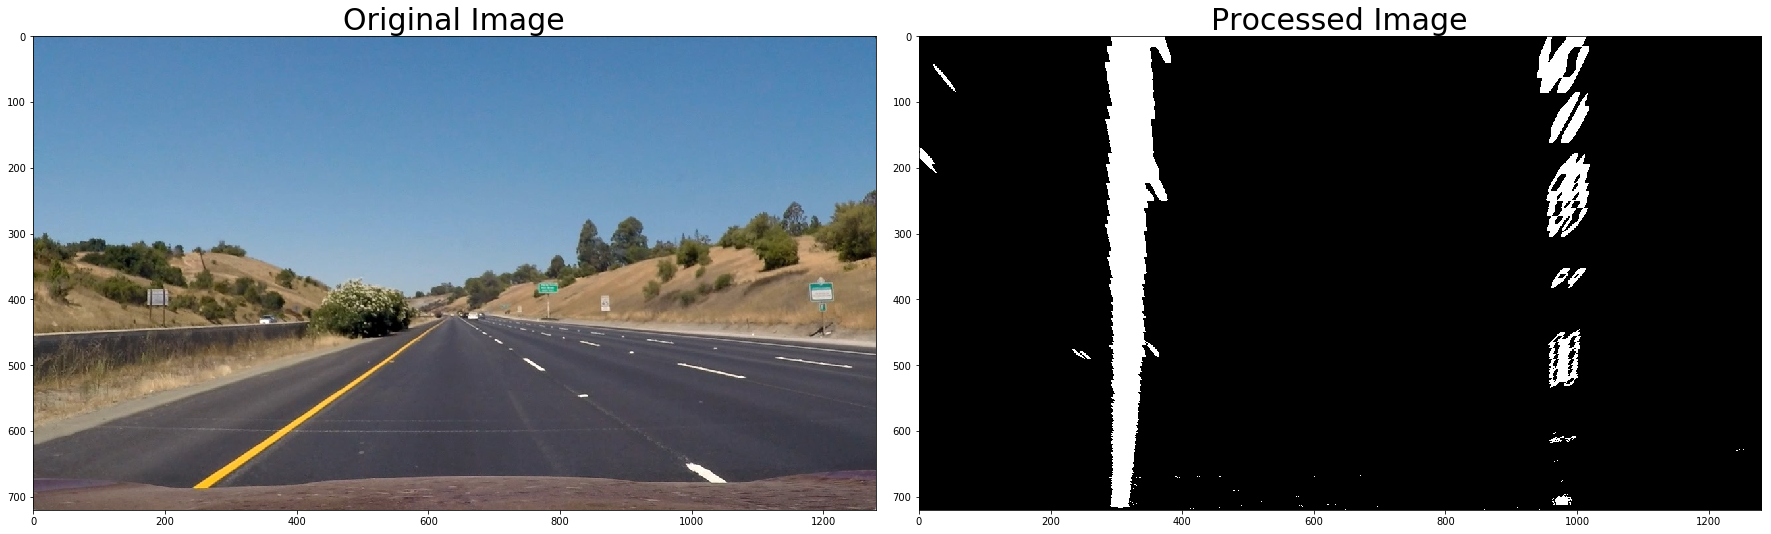

In [12]:
img = cv2.imread('test_images/straight_lines1.jpg')
pipelined_img, undist = source_img_to_wrap(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(img))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(pipelined_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



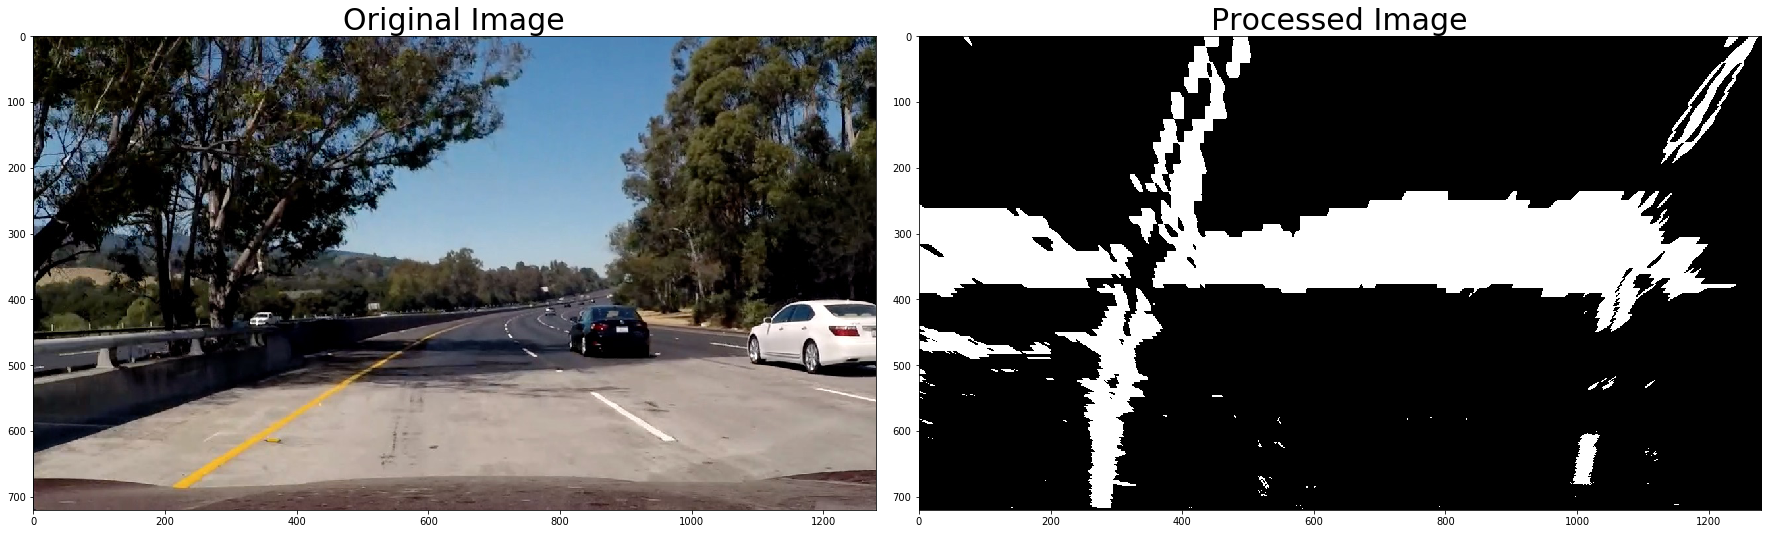

In [13]:
img = cv2.imread('test_images/test5.jpg')
pipelined_img, undist = source_img_to_wrap(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(img))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(pipelined_img, cmap='gray')
ax2.set_title('Processed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Line finding


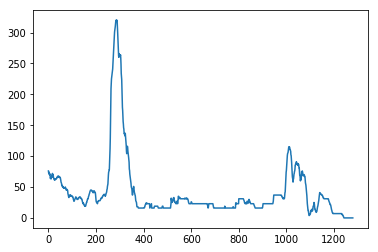

In [14]:
histogram = np.sum(pipelined_img[pipelined_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


(720, 0)

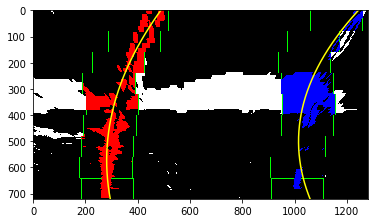

In [15]:

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Create an output image to draw on and  visualize the result
out_img = np.dstack((pipelined_img, pipelined_img, pipelined_img))*255

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(pipelined_img.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = pipelined_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = pipelined_img.shape[0] - (window+1)*window_height
    win_y_high = pipelined_img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# polynomials in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)



# Generate x and y values for plotting
ploty = np.linspace(0, pipelined_img.shape[0]-1, pipelined_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [16]:

left_curverad = ((1 + (2*left_fit_cr[0]*imshape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*imshape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

print(left_curverad, right_curverad)


261.096719661 180.858373082


In [17]:
def sliding_window_fit(pipelined_img):
    histogram = np.sum(pipelined_img[pipelined_img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(pipelined_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = pipelined_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = pipelined_img.shape[0] - (window+1)*window_height
        win_y_high = pipelined_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        leftx_new = 0
        rightx_new = 0
        if len(good_left_inds) > minpix:
            leftx_new = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current
        if len(good_right_inds) > minpix:        
            rightx_new = np.int(np.mean(nonzerox[good_right_inds])) - rightx_current

        # move window in parallel
        if (leftx_new > 0) and (rightx_new > 0):
            leftx_current += int((leftx_new + rightx_new) / 2)
            rightx_current += int((leftx_new + rightx_new) / 2)
        if (leftx_new < 0) and (rightx_new < 0):
            leftx_current += int((leftx_new + rightx_new) / 2)
            rightx_current += int((leftx_new + rightx_new) / 2)

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # polynomials in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*pipelined_img.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*pipelined_img.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    curve = (left_curverad + right_curverad) / 2
    
    left_bottom = int(left_fit[0]*pipelined_img.shape[0]**2 + left_fit[1]*pipelined_img.shape[0] + left_fit[2])
    right_bottom = int(right_fit[0]*pipelined_img.shape[0]**2 + right_fit[1]*pipelined_img.shape[0] + right_fit[2])
    
    vehical_dev = (((left_bottom + right_bottom) / 2.0) - (pipelined_img.shape[1] / 2.0)) * xm_per_pix
    
    return left_fit, right_fit, curve, vehical_dev



In [18]:
def previous_line_fit(pipelined_img, left_fit, right_fit):
    nonzero = pipelined_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 25
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # polynomials in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*pipelined_img.shape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*pipelined_img.shape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curve = (left_curverad + right_curverad) / 2
    
    left_bottom = int(left_fit[0]*pipelined_img.shape[0]**2 + left_fit[1]*pipelined_img.shape[0] + left_fit[2])
    right_bottom = int(right_fit[0]*pipelined_img.shape[0]**2 + right_fit[1]*pipelined_img.shape[0] + right_fit[2])
    
    vehical_dev = (((left_bottom + right_bottom) / 2.0) - (pipelined_img.shape[1] / 2.0)) * xm_per_pix
    
    return left_fit, right_fit, curve, vehical_dev


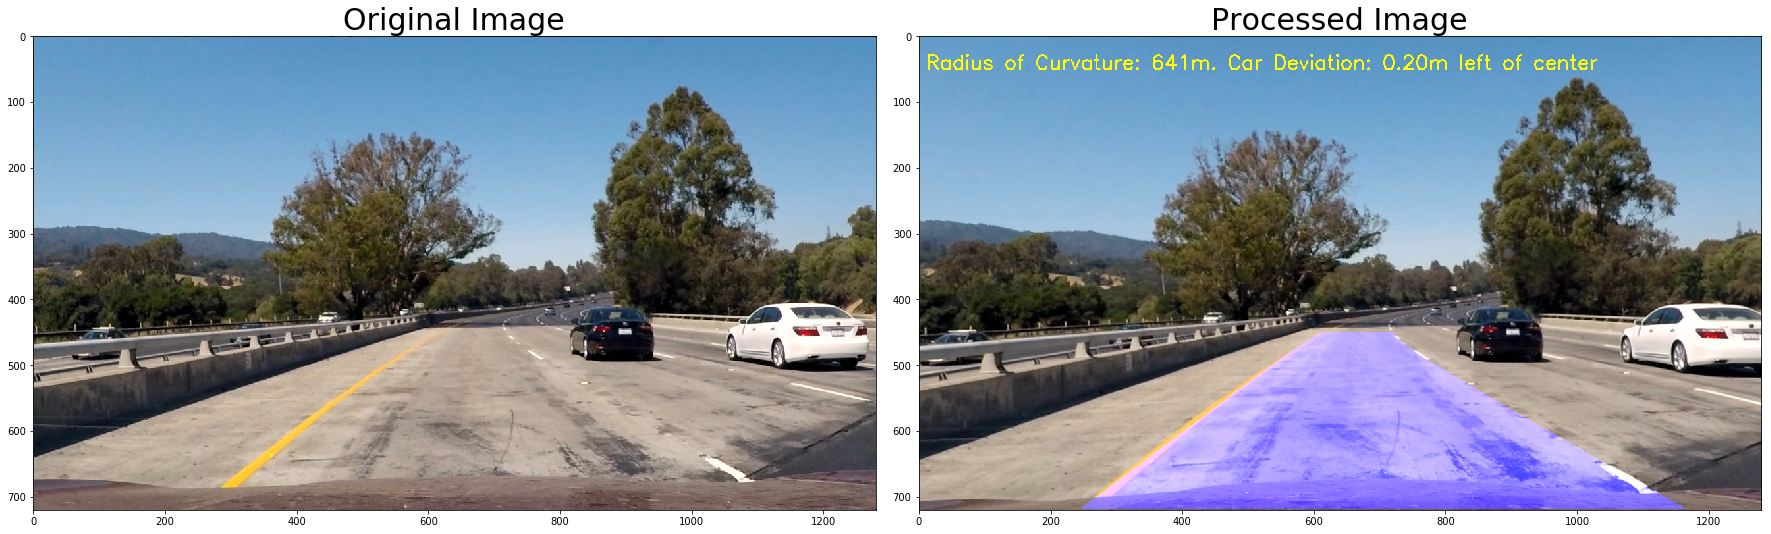

In [19]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,50)
fontScale              = 1
fontColor              = (0,255,255)
lineType               = 2


def unwarp_fitted_lines(pipelined_img, left_fit, right_fit):
    window_img = np.zeros_like(pipelined_img)
    for y in range(pipelined_img.shape[0]):
        left_fitx = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
        right_fitx = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
        if left_fitx < 0:
            left_fitx = 0
        if right_fitx < 0:
            right_fitx = 0
        if left_fitx >= pipelined_img.shape[1]:
            left_fitx = pipelined_img.shape[1] - 1
        if right_fitx >= pipelined_img.shape[1]:
            right_fitx = pipelined_img.shape[1] - 1

        for x in range(left_fitx, right_fitx):
            window_img[y][x] = 255
    unwarped = cv2.warpPerspective(window_img, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    return unwarped
    
img = cv2.imread('test_images/test1.jpg')
pipelined_img, undist = source_img_to_wrap(img)
left_fit, right_fit, curve, vehical_dev = sliding_window_fit(pipelined_img)
unwarped = unwarp_fitted_lines(pipelined_img, left_fit, right_fit)
mask = np.zeros_like(undist)
mask[:,:,0] = unwarped
masked_img = cv2.bitwise_or(undist, mask)
text = "Radius of Curvature: " + str(int(curve)) + "m. Car Deviation: " + "{0:.2f}".format(abs(vehical_dev)) + "m "
if (vehical_dev < 0):
    text += "right of center"
else:
    text += "left of center"
cv2.putText(masked_img,text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bgr_to_rgb(img))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(bgr_to_rgb(masked_img))
ax2.set_title('Processed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [20]:

prev_left_fit = None
prev_right_fit = None
prev_curve = None
prev_vehical_dev = None
miss_frame = 0

def process_image(img):
    global prev_left_fit
    global prev_right_fit
    global prev_curve
    global prev_vehical_dev
    global miss_frame
    #img = rgb_to_bgr(img)
    pipelined_img, undist = source_img_to_wrap_2(img)
    if prev_vehical_dev is None:
        left_fit, right_fit, curve, vehical_dev = sliding_window_fit(pipelined_img)
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        prev_curve = curve
        prev_vehical_dev = vehical_dev
        miss_frame = 0
    else:
        left_fit, right_fit, curve, vehical_dev = previous_line_fit(pipelined_img, prev_left_fit, prev_right_fit)
    
    # try sliding window fit if previous_line_fit don't look good
    if abs(vehical_dev - prev_vehical_dev) > 0.1:
        left_fit, right_fit, curve, vehical_dev = sliding_window_fit(pipelined_img)
        
    # decide whether we use the new calculation or keep the old
    if (abs(vehical_dev - prev_vehical_dev) > 0.2) and (miss_frame < 10):
        left_fit = prev_left_fit
        right_fit = prev_right_fit
        curve = prev_curve
        vehical_dev = prev_vehical_dev
        miss_frame += 1
    else:
        prev_left_fit = left_fit
        prev_right_fit = right_fit
        prev_curve = curve
        prev_vehical_dev = vehical_dev

    unwarped = unwarp_fitted_lines(pipelined_img, left_fit, right_fit)
    mask = np.zeros_like(undist)
    mask[:,:,2] = unwarped
    masked_img = cv2.bitwise_or(undist, mask)
    text = "Radius of Curvature: " + str(int(curve)) + "m. Car Deviation: " + "{0:.2f}".format(abs(vehical_dev)) + "m "
    if (vehical_dev < 0):
        text += "right of center"
    else:
        text += "left of center"
    cv2.putText(masked_img,text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)
    return masked_img

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
clip1 = VideoFileClip("project_video.mp4")
video_output = 'project_video_out3.mp4'
#out_clip = clip1.fl_image(process_image).subclip(30,50)
out_clip = clip1.fl_image(process_image)
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_out3.mp4
[MoviePy] Writing video project_video_out3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:39<00:00,  5.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out3.mp4 

Wall time: 3min 40s


In [23]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))